In [1]:
import numpy as np
import matplotlib.pyplot as plt
import importlib
import os
import pickle
import scipy.io as spio
import scipy.stats as sp
import mat73
import seaborn as sns
from scipy.special import factorial
from scipy.special import logsumexp
import pandas as pd
from replay_structure.utils import get_marginal_sum

In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
%matplotlib widget

In [3]:
import replay_structure.structure_models as models
from replay_structure.run_snippet_preprocessing import Run_Snippet_Preprocessing


from replay_structure.metadata import (
    Likelihood_Function,
    Model,
    Diffusion,
    Momentum,
    Stationary,
    Stationary_Gaussian,
    Random,
    Data_Type,
    string_to_data_type,
    string_to_model,
    Session_Indicator,
    string_to_session_indicator,
    string_to_likelihood_function,
)

## load structure data

In [4]:
bin_size_cm=5
#time_window_ms=3
time_window_ms=15

In [5]:
RESULTS_PATH = "/home/katharina/Documents/Studium/MIT/project/1D/results"
filename = RESULTS_PATH+'/structure_analysis_input/Data4Pset_ripples_'+str(bin_size_cm)+'cm_'+str(time_window_ms)+'ms_poisson.obj'
filename_15_rd = RESULTS_PATH+'/structure_analysis_input/RD_Data4Pset_ripples_'+str(bin_size_cm)+'cm_'+str(time_window_ms)+'ms_poisson.obj'
filename_run200 = RESULTS_PATH+'/structure_analysis_input/Data4Pset_fullrunthreshold_'+str(bin_size_cm)+'cm_200ms_poisson.obj'
filename_run200 = RESULTS_PATH+'/structure_analysis_input/Data4Pset_fullrunthreshold_'+str(bin_size_cm)+'cm_200ms_poisson.obj'
filename_run15 = RESULTS_PATH+'/structure_analysis_input/Data4Pset_fullrun_'+str(bin_size_cm)+'cm_15ms_poisson.obj'
filename_run_raw = RESULTS_PATH+'/Data4Pset_full_run_'+str(bin_size_cm)+'cm_200ms_poisson.obj'
filename_full200 = RESULTS_PATH+'/structure_analysis_input/Data4Pset_fulldata_'+str(bin_size_cm)+'cm_200ms_poisson.obj'
filename_full200_rd = RESULTS_PATH+'/structure_analysis_input/RD_Data4Pset_fulldata_'+str(bin_size_cm)+'cm_200ms_poisson.obj'
filename_full15 = RESULTS_PATH+'/structure_analysis_input/Data4Pset_fulldata_'+str(bin_size_cm)+'cm_15ms_poisson.obj'

In [6]:
with open(filename, "rb") as file_object:
    raw_data = file_object.read()
    structure_data = pickle.loads(raw_data)

In [7]:
with open(filename_15_rd, "rb") as file_object:
    raw_data = file_object.read()
    structure_data_RD = pickle.loads(raw_data)

In [8]:
with open(filename_run200, "rb") as file_object:
    raw_data = file_object.read()
    structure_data_run200 = pickle.loads(raw_data)

In [9]:
with open(filename_run15, "rb") as file_object:
    raw_data = file_object.read()
    structure_data_run15 = pickle.loads(raw_data)

In [10]:
with open(filename_run_raw, "rb") as file_object:
    raw_data = file_object.read()
    data_run_raw = pickle.loads(raw_data)

In [11]:
with open(filename_full15, "rb") as file_object:
    full_data = file_object.read()
    full_data15 = pickle.loads(full_data)

In [12]:
with open(filename_full200, "rb") as file_object:
    full_data = file_object.read()
    full_data200 = pickle.loads(full_data)

In [13]:
with open(filename_full200_rd, "rb") as file_object:
    full_data = file_object.read()
    full_data200_rd = pickle.loads(full_data)

In [14]:
runtimes = np.loadtxt('runtimes.txt', dtype =float)

In [15]:
data_run_raw.run_info['true_trajectories_cm'].keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43])

## load RD Emisson Prob

In [16]:
path = '../data/'
ripple_data_new = spio.loadmat(path+'decodedPosition15ms.mat')

In [17]:
ripple_times = ripple_data_new['newRipples']

In [18]:
RESULTS_PATH = "/home/katharina/Documents/Studium/MIT/project/data/"
rd_data_ = mat73.loadmat(RESULTS_PATH+'decodedPositionEmissionProbUpdated.mat')
rd_data_old = spio.loadmat(RESULTS_PATH+'decodedPositionEmissionProb.mat')

In [19]:
rd_data_old['A']['time200ms'][0][0].squeeze()

array([6199.10001964, 6199.30005891, 6199.50009818, ..., 7047.46656849,
       7047.66660776, 7047.86664703])

In [20]:
rd_data = rd_data_['B']
rd_data.keys()

dict_keys(['bctr', 'ep_15', 'ep_15EK', 'ep_15smooth', 'ep_200', 'ep_200EK', 'ep_200smooth', 'ep_dir_15', 'ep_dir_200', 'fR', 'pdf_15', 'pdf_15EK', 'pdf_15smooth', 'pdf_200', 'pdf_200EK', 'pdf_200smooth', 'pdf_dir_15', 'pdf_dir_200'])

In [21]:
ep15 = rd_data['ep_15smooth']
ep_dir_15 = rd_data['ep_dir_15']
ep200 = rd_data['ep_200']
ep_dir_200 = rd_data['ep_dir_200']
time15 = rd_data_old['A']['time15ms'][0][0].squeeze()
time200 = rd_data_old['A']['time200ms'][0][0].squeeze()

In [22]:
spikemats_fullripple = dict()
for ripple_num in range(ripple_times.shape[0]):
    ripple_start = ripple_times[ripple_num][0]
    ripple_end = ripple_times[ripple_num][1]
    timebin_bool = (time15>ripple_start) == (time15<ripple_end)
    spikemats_fullripple[ripple_num] = ep15[:,timebin_bool]

In [23]:
spikemats_fullrun = dict()
for run in range(runtimes.shape[0]):
    start = runtimes[run][0]
    end = runtimes[run][1]
    timebin_bool = (time200>start) == (time200<end)
    spikemats_fullrun[run] = ep200[:,timebin_bool]

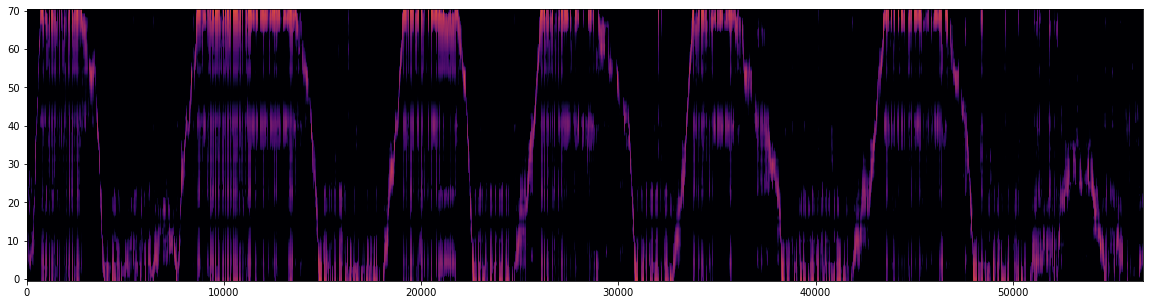

In [24]:
plt.figure(figsize=(20,5))
plt.imshow(get_marginal_sum(ep15), aspect='auto', origin='lower', cmap='inferno',vmin=np.log(.001), vmax=np.log(4))

In [22]:
spikemats_fullripple_rd = dict()
for ripple_num in range(ripple_times.shape[0]):
    ripple_start = ripple_times[ripple_num][0]
    ripple_end = ripple_times[ripple_num][1]
    timebin_bool = (time15>ripple_start) == (time15<ripple_end)
    spikemats_fullripple_rd[ripple_num] = ep_dir_15[:,timebin_bool]

In [23]:
spikemats_fullrun_rd = dict()
for run in range(runtimes.shape[0]):
    start = runtimes[run][0]
    end = runtimes[run][1]
    timebin_bool = (time200>start) == (time200<end)
    spikemats_fullrun_rd[run] = ep_dir_200[:,timebin_bool]

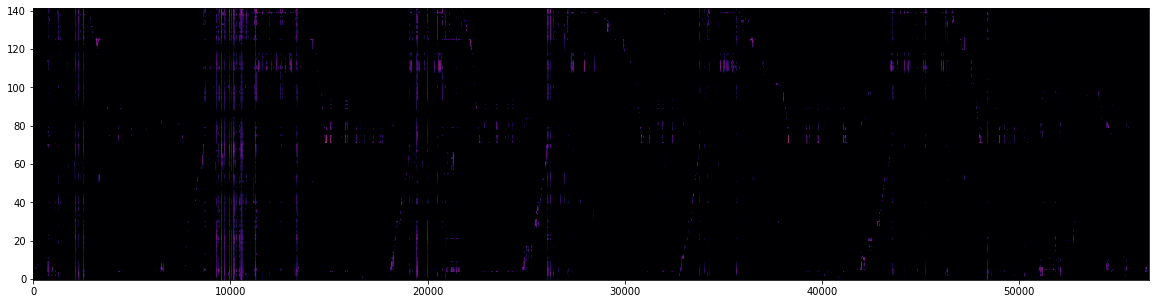

In [24]:
plt.figure(figsize=(20,5))
plt.imshow(get_marginal_sum(ep_dir_15), aspect='auto', origin='lower', cmap='inferno',vmin=np.log(.001), vmax=np.log(4))

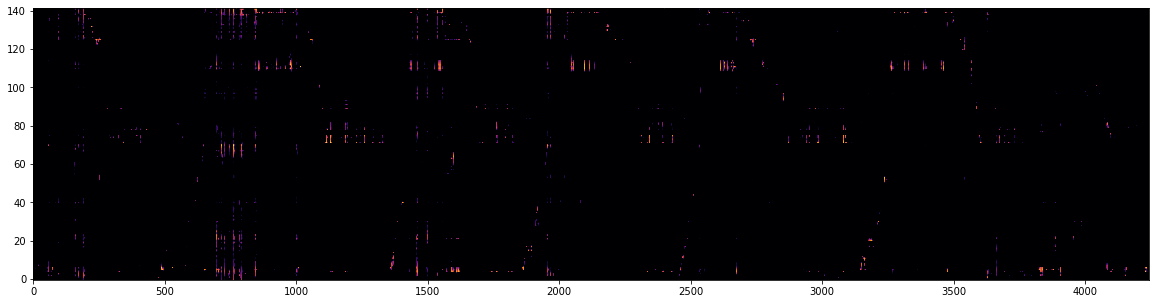

In [26]:
plt.figure(figsize=(20,5))
plt.imshow(get_marginal_sum(ep_dir_200), aspect='auto', origin='lower', cmap='inferno',vmin=np.log(.0000000001), vmax=np.log(4))

In [ ]:
spikemats_fullripple
spikemats_fullripple_rd

spikemats_fullrun
spikemats_fullripple_rd

# Tests

In [27]:
emission_prob_time_window = (
                    structure_data.params.time_window_s
                    * structure_data.params.likelihood_function_params.rate_scaling
                )

In [28]:
emission_prob_time_window_run = (
                    0.2
                    * structure_data.params.likelihood_function_params.rate_scaling
                )

In [29]:
structure_data.params.likelihood_function_params.rate_scaling
# scaling_factors = ripple_mean_frs / run_mean_frs

2.5

In [30]:
index = 39
xbins_rd = 36
ripple_fk = spikemats_fullripple[39][:,2:-2]
ripple_fk_rd = spikemats_fullripple_rd[39][:,2:-2]
ripple_fk.shape

(71, 8)

In [168]:
run_fk_1 = spikemats_fullrun[1]
run_fk_rd_1 = spikemats_fullrun_rd[1]

run_fk_2 = spikemats_fullrun[17]
run_fk_rd_2 = spikemats_fullrun_rd[17]

## Random

In [19]:
def random(emission_probabilities_log, x_bins):
    full_sum = emission_probabilities_log - np.log(
            x_bins )
    
    # aprox. max for each timepoint
    sum_z = logsumexp(full_sum, axis=0)
    model_evidence = np.sum(sum_z)
    marginals = np.exp(emission_probabilities_log)
    return model_evidence, marginals

def calc_poisson_emission_probabilities_log(spikemat, place_fields, time_window_s):
    """This function calculates the emission probabilities p(x_t|z_t)
    input: spikemat (T x Ncells), place_fields (Ncells x Ngrid), time_window_s
    output: (Ngrid x T matrix) of emission probabilities over time."""
    (n_timesteps, n_cells) = np.shape(spikemat)  # 12,53
    (n_cells, n_grid) = np.shape(place_fields)  # 53,71
    log_pfs = np.log(place_fields).T  # 71,53
    # compute pf_spikes sum: sum_n[x_t*ln[f_n(z_t)*delta_t]]
    pf_spikes_sum = np.zeros((n_timesteps, n_grid))  # 12,71
    for t in range(n_timesteps):
        x = spikemat[t]
        pf_spikes_sum[t] = np.sum(log_pfs * x, axis=1)
    time_window_spikes_sum = np.sum(spikemat * np.log(time_window_s), axis=1)  # 12,
    # calcualte pf_sum: sum_n[f_n(z_t)*delta_t]]
    pf_sum = time_window_s * np.sum(place_fields, axis=0)  # 71,
    spikes_sum = np.sum(np.log(factorial(spikemat)), axis=1)  # 12,
    # calculate emission probs
    pf_sum_norm = (pf_spikes_sum.T + time_window_spikes_sum).T - pf_sum
    emission_probabilities_log = pf_sum_norm.T - spikes_sum
    return emission_probabilities_log

In [33]:
emission_prob_time_window_run = 0.015
emission_probabilities = np.exp(calc_poisson_emission_probabilities_log(
                full_data200_rd.spikemats[0],
                full_data200_rd.pf_matrix,
                0.015,
            ))

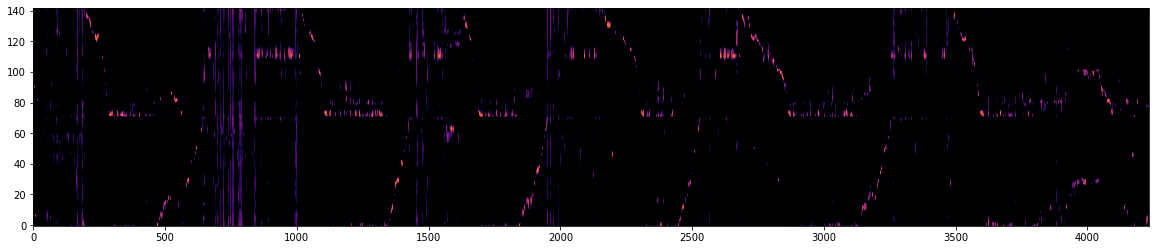

In [34]:
plt.figure(figsize=(20,4))
plt.imshow(get_marginal_sum(emission_probabilities), aspect='auto', origin='lower', cmap='inferno',vmin=np.log(.001), vmax=np.log(4))

In [33]:
emission_prob_time_window_run = 0.015
emission_probabilities = np.exp(calc_poisson_emission_probabilities_log(
                full_data15.spikemats[0],
                full_data15.pf_matrix,
                0.015,
            ))

In [227]:
print(ep15.min(), ep15.max()) 

1.3426306569410131e-288 1.7056661902277726e-82


In [229]:
print(ep15.min(), ep15.max())  #smooth

5.230355321823848e-241 1.1434362333593386e-82


In [225]:
print(ep15.min(), ep15.max()) #EK

1.4753028190714157e-121 9.779042182546704e-86


In [219]:
print(emission_probabilities.min(), emission_probabilities.max())

6.949778085703518e-48 0.5948830471480396


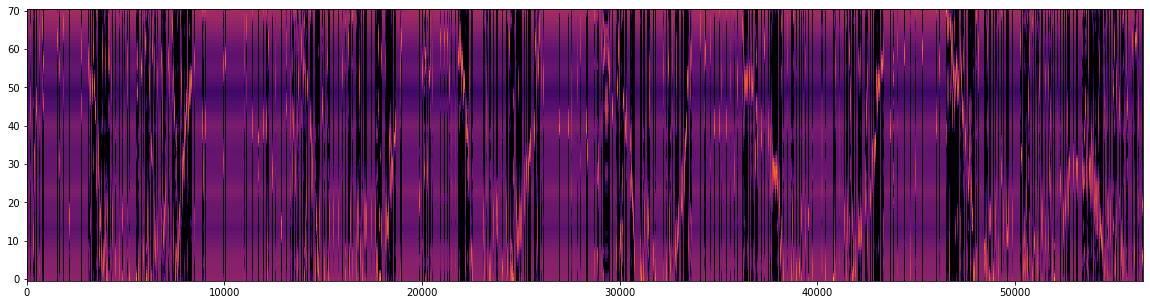

In [34]:
plt.figure(figsize=(20,5))
#marginal_plot = get_marginal_sum(marginals)
plt.imshow(get_marginal_sum(emission_probabilities), aspect='auto', origin='lower', cmap='inferno', 
           vmin=np.log(.001), 
           vmax=np.log(4),
           interpolation='none')

In [194]:
# np.savetxt("emission_probabilities15.txt", emission_probabilities)

In [35]:
emission_prob_time_window_run = 0.2
emission_probabilities = np.exp(calc_poisson_emission_probabilities_log(
                full_data200.spikemats[0],
                full_data200.pf_matrix,
                emission_prob_time_window_run,
            ))

In [36]:
emission_probabilities.min()

1.6381345717659422e-158

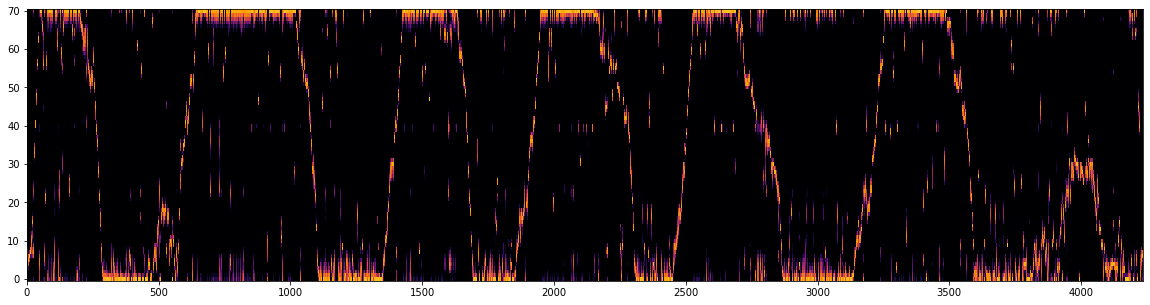

In [37]:
plt.figure(figsize=(20,5))
#marginal_plot = get_marginal_sum(marginals)
plt.imshow(get_marginal_sum(emission_probabilities), aspect='auto', origin='lower', cmap='inferno', 
           vmin=np.log(.001), 
           vmax=np.log(3),
           interpolation='none')

In [199]:
np.savetxt("emission_probabilities200.txt", emission_probabilities)

## Stationary

In [38]:
def stationary(emission_probability_log, x_bins):
    joint_probability = emission_probability_log - np.log(
        x_bins
    )
    model_evidence = logsumexp(joint_probability)
    marginals = np.exp(emission_probability_log - emission_probability_log.max())
    return model_evidence, marginals

def calc_poisson_emission_probability_log(spikemat, place_fields, time_window_s):
    (n_timesteps, n_cells) = np.shape(spikemat)  # 12,53
    (n_cells, n_grid) = np.shape(place_fields)  # 53,71
    x = np.sum(spikemat, axis=0)  # 53
    log_pfs = np.log(place_fields).T  # 71,53
    pf_spikes_sum = np.sum(log_pfs * x, axis=1)
    time_window_sum = np.sum(spikemat) * np.log(time_window_s)
    pf_sum = time_window_s * n_timesteps * np.sum(place_fields, axis=0)
    spikes_sum = np.sum(np.log(factorial(spikemat)))
    pf_sum_norm = pf_spikes_sum + time_window_sum - pf_sum
    emission_probability_log = pf_sum_norm - spikes_sum
    return emission_probability_log

## Stationary gaussian

In [35]:
structure_data_RD.params.n_bins_x

71

In [25]:
sd_meters = 0.08
sd_bins = (sd_meters*100) /structure_data.params.bin_size_cm

def stat_gaus(emission_probabilities, xbins, latent_mat):
    sum_z = np.matmul(
        emission_probabilities.T, latent_mat
    )
    sum_t = np.sum(np.log(sum_z), axis=0)
    model_evidence = logsumexp(-np.log(xbins) + sum_t)
    marginals = np.matmul(
        emission_probabilities.T, latent_mat.T
    ).T
    return model_evidence, marginals

def _calc_latent_probabilities_1D(xbins, norm=1):
    latent_mat = np.zeros((
                xbins,
                xbins))
    x = np.arange(xbins)
    for m in range(xbins):
        this_prob = sp.multivariate_normal(m, sd_bins ** 2).pdf(np.transpose(x))
        latent_mat[:, m] = this_prob / (norm*this_prob.sum())
    return latent_mat

In [26]:
latent_probabilities_normalized = _calc_latent_probabilities_1D(71)

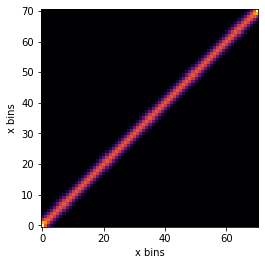

In [31]:
plt.figure()
plt.imshow(latent_probabilities_normalized, origin='lower', cmap='inferno',interpolation='none')
plt.xlabel('x bins')
plt.ylabel('x bins')
plt.savefig('fig/latent', dpi=500, transparent=True)

In [42]:
latent_probabilities_normalized = np.vstack((latent_probabilities_normalized,latent_probabilities_normalized))
latent_probabilities_normalized = np.hstack((latent_probabilities_normalized,latent_probabilities_normalized))

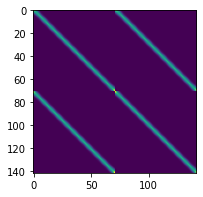

In [43]:
plt.figure(figsize=(3,3))
plt.imshow(latent_probabilities_normalized)

## Diffusion

In [37]:
import replay_structure.forward_backward as fb

In [38]:
def diffusion(emission_probabilities, transition_matrix, sd_bins, time_window_s, xbins, norm=1):
    forward_backward_input = dict()
    forward_backward_input["initial_state_prior"] = np.ones(xbins) / xbins
    forward_backward_input["transition_matrix"] = transition_matrix
    forward_backward_input["emission_probabilities"] = emission_probabilities
    forward_backward_output = fb.Forward_Backward(
        forward_backward_input
    ).run_forward_backward_algorithm("no joints")
    model_ev = forward_backward_output["data_likelihood"]
    marginals = forward_backward_output["latent_marginals"].T
    return model_ev, marginals

def _calc_transition_matrix(sd_bins, time_window_s, xbins, norm=1):
    """NxN matrix"""
    transition_mat = np.zeros(
        (xbins, xbins)
    )
    j = np.arange(xbins)  # t
    for i in range(xbins):  # t-1
        this_transition = np.exp(
            -((j - i) ** 2)
            / (2 * sd_bins ** 2 * time_window_s)
        )
        transition_mat[:, i] = this_transition / (norm*np.sum(this_transition))
    return transition_mat

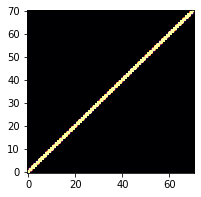

In [47]:
plt.figure(figsize=(3,3))
plt.imshow(_calc_transition_matrix(sd_bins,  0.015, 71, norm=1),aspect='auto', origin='lower', cmap='inferno',vmin=0, vmax=0.1)

In [ ]:
# _initialize_forward_backward_input
forward_backward_input = dict()
n_grid = structure_data.params.n_bins_x
forward_backward_input["initial_state_prior"] = np.ones(n_grid) / n_grid
forward_backward_input["transition_matrix"] = _calc_transition_matrix(sd_bins)

forward_backward_input["emission_probabilities"] = np.exp(calc_poisson_emission_probabilities_log(
                structure_data.spikemats[39],
                structure_data.pf_matrix,
                emission_prob_time_window,
            ))

(n_states, n_timesteps) = forward_backward_input["emission_probabilities"].shape
alphas = np.zeros((n_timesteps, n_states))
conditionals = np.zeros(n_timesteps)
    
alphas_init = (forward_backward_input["initial_state_prior"]
            * forward_backward_input["emission_probabilities"][:, 0])
alphas0 = alphas_init / np.sum(alphas_init)
conditionals0 = np.sum(alphas_init)

# calculate alpha_0:T recursively forward in time
for n in range(1, n_timesteps):
    alphas_init = forward_backward_input["emission_probabilities"][:, n] * np.matmul(
        alphas[n - 1], forward_backward_input["transition_matrix"].T
    )
    print(alphas_init.shape)  # p(z_t, x_1:t) (71,)
    conditionals[n] = np.sum(alphas_init)  # p(x_t:t)
    alphas[n] = alphas_init / conditionals[n]  # normalize

In [357]:
transit_mat = _calc_transition_matrix(sd_bins)

In [358]:
transit_mat = np.vstack((transit_mat,transit_mat))
transit_mat = np.hstack((transit_mat,transit_mat))

In [369]:
np.sum(transition_mat[:,71])

1.0

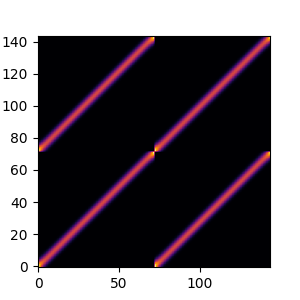

In [367]:
plt.figure(figsize=(3,3))
plt.imshow(transition_mat,aspect='auto', origin='lower', cmap='inferno')

## Momentum

In [49]:
import torch

In [62]:
# ripples "sd_meters": 130, "decay": 100, "sd_0_meters": 0.03
# run snippets "sd_meters": 2.4, "decay": 20, "sd_0_meters": 0.0
sd_meters = 130
sd_0_meters = 0.15
sd_bins = (sd_meters*100) /structure_data.params.bin_size_cm
sd_0_bins = (sd_0_meters*100) /structure_data.params.bin_size_cm
decay = 50


def momentum(emission_probabilities, initial_transition, transition_matrix, xbins):
        forward_backward_input = dict()
        forward_backward_input["initial_state_prior"] = torch.from_numpy(
            np.ones(xbins)/xbins)

        forward_backward_input["initial_transition"] = torch.from_numpy(initial_transition)
        forward_backward_input["transition_matrix"] = torch.from_numpy(transition_matrix)
        forward_backward_input["emission_probabilities"] = emission_probabilities
        
        forward_backward_output = fb.Forward_Backward_order2(forward_backward_input).run_forward_backward_algorithm(
            plotting=True)
        model_ev = forward_backward_output["data_likelihood"]  # .numpy()
        marginals = forward_backward_output["latent_marginals"].numpy().T
        return model_ev, marginals

def _calc_order2_transition_matrix(sd: float, decay: float, time_window_s, xbins ):
    """(n x n x n) matrix"""
    var_scaled = (
        (sd ** 2 * time_window_s ** 2)
        / (2 * decay)
        * (1 - np.exp(-2 * decay * time_window_s))
    )
    transition_mat = np.zeros(
        (
            xbins,
            xbins,
            xbins,
        )
    )
    m = np.arange(xbins)  # t x/y
    for i in range(xbins):  # t-2 x/y
        for k in range(xbins):  # t-1 x/y
            mean = (
                1 + np.exp(-time_window_s * decay)
            ) * k - (np.exp(-time_window_s * decay)) * i
            this_transition = np.exp(-((m - mean) ** 2) / (2 * var_scaled))
            norm_sum = 2*np.sum(this_transition)
            if norm_sum == 0:
                max_prob_ind = (
                    0 if mean < 0 else xbins - 1
                )
                this_transition[max_prob_ind] = 1
                transition_mat[:, k, i] = this_transition
            else:
                transition_mat[:, k, i] = this_transition / norm_sum
    return transition_mat

In [294]:
trans_mat_2 = _calc_order2_transition_matrix(sd_bins, decay)

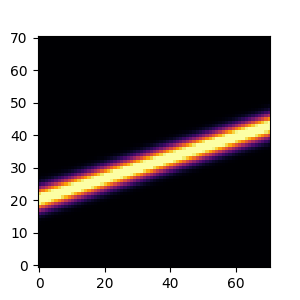

In [81]:
plt.figure(figsize=(3,3))
plt.imshow(_calc_order2_transition_matrix(sd_bins, decay)[30,:,:],aspect='auto', origin='lower', cmap='inferno',vmin=0, vmax=0.1)

In [298]:
# _initialize_forward_backward_input
forward_backward_input = dict()
forward_backward_input["initial_state_prior"] = torch.from_numpy(
    np.ones(structure_data.params.n_bins_x)/structure_data.params.n_bins_x)

forward_backward_input["initial_transition"] = torch.from_numpy(
    _calc_order1_transition_matrix1D(sd_0_bins)
)
forward_backward_input["transition_matrix"] = torch.from_numpy(
    _calc_order2_transition_matrix(sd_bins, decay))

forward_backward_input["emission_probabilities"] = torch.from_numpy(
                np.exp(calc_poisson_emission_probabilities_log( structure_data.spikemats[39],
                structure_data.pf_matrix,
                emission_prob_time_window,))
            )

In [299]:
forward_backward_output = fb.Forward_Backward_order2(forward_backward_input).run_forward_backward_algorithm(
            plotting=True
        )

-82.86837475839318984


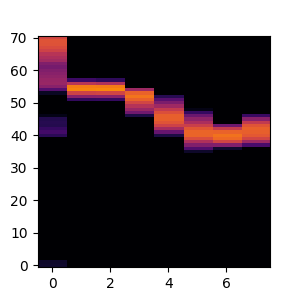

In [300]:
print(forward_backward_output["data_likelihood"])
plt.figure(figsize=(3,3))
marginal_plot = forward_backward_output["latent_marginals"].numpy().T
marginal_plot = get_marginal_sum(marginal_plot)
plt.imshow(marginal_plot, aspect='auto', origin='lower', cmap='inferno',vmin=np.log(.001), vmax=np.log(4))

In [310]:
sd_bins = (sd_meters*100) /10
sd_0_bins = (sd_0_meters*100) /10

In [311]:
transition_mat0 = np.zeros(
    (xbins_rd, xbins_rd)
)
j = np.arange(xbins_rd)  # t
for i in range(xbins_rd):  # t-1
    this_transition = np.exp(
        -((j - i) ** 2)
        / (2 * sd_0_bins ** 2 * structure_data.params.time_window_s)
    )
    transition_mat0[:, i] = this_transition / (np.sum(this_transition))
    
    
    
var_scaled = (
    (sd_bins ** 2 * structure_data.params.time_window_s ** 2)
    / (2 * decay)
    * (1 - np.exp(-2 * decay * structure_data.params.time_window_s))
)
transition_mat = np.zeros(
    (
        xbins_rd,
        xbins_rd,
        xbins_rd,
    )
)
m = np.arange(xbins_rd)  # t x/y
for i in range(xbins_rd):  # t-2 x/y
    for k in range(xbins_rd):  # t-1 x/y
        mean = (
            1 + np.exp(-structure_data.params.time_window_s * decay)
        ) * k - (np.exp(-structure_data.params.time_window_s * decay)) * i
        this_transition = np.exp(-((m - mean) ** 2) / (2 * var_scaled))
        norm_sum = np.sum(this_transition)
        if norm_sum == 0:
            max_prob_ind = (
                0 if mean < 0 else xbins_rd - 1
            )
            this_transition[max_prob_ind] = 1
            transition_mat[:, k, i] = this_transition
        else:
            transition_mat[:, k, i] = this_transition / norm_sum

In [312]:
forward_backward_input = dict()
forward_backward_input["initial_state_prior"] = torch.from_numpy(
    np.ones(xbins_rd)/xbins_rd)

forward_backward_input["initial_transition"] = torch.from_numpy(transition_mat0)
forward_backward_input["transition_matrix"] = torch.from_numpy(transition_mat)

forward_backward_input["emission_probabilities"] = torch.from_numpy(ripple_fk)

forward_backward_output = fb.Forward_Backward_order2(forward_backward_input).run_forward_backward_algorithm(
            plotting=True
        )

32.07783115567637309


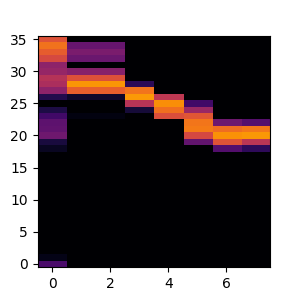

In [313]:
print(forward_backward_output["data_likelihood"])
plt.figure(figsize=(3,3))
marginal_plot = forward_backward_output["latent_marginals"].numpy().T
marginal_plot = get_marginal_sum(marginal_plot)
plt.imshow(marginal_plot, aspect='auto', origin='lower', cmap='inferno',vmin=np.log(.001), vmax=np.log(4))

# Comparison

In [167]:
run_ind = 12

In [168]:
emission_probabilities = np.exp(calc_poisson_emission_probabilities_log(
                structure_data_run15.spikemats[run_ind],
                structure_data_run15.pf_matrix,
                0.015))

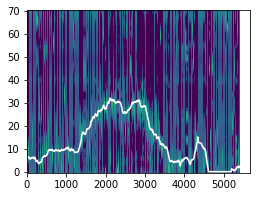

In [169]:
plt.figure(figsize=(4,3))
plt.imshow(get_marginal_sum(emission_probabilities),aspect='auto', origin='lower', vmin=np.log(.001), vmax=np.log(4),interpolation='none')
t = np.linspace(0 , emission_probabilities.shape[1], data_run_raw.run_info['true_trajectories_cm'][run_ind].shape[0])
plt.plot(t, data_run_raw.run_info['true_trajectories_cm'][run_ind]/5, c='white')

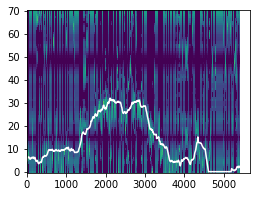

In [174]:
plt.figure(figsize=(4,3))
plt.imshow(get_marginal_sum(run_fk), aspect='auto', origin='lower', vmin=np.log(.001), vmax=np.log(4),interpolation='none')
t = np.linspace(0 , run_fk.shape[1], data_run_raw.run_info['true_trajectories_cm'][run_ind].shape[0])
plt.plot(t, data_run_raw.run_info['true_trajectories_cm'][run_ind]/5, c='white')

# Models

In [183]:
# random

-1026.1032276118326
-577.2097795635284


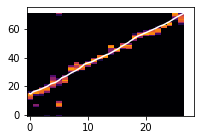

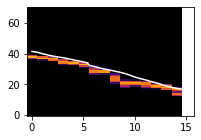

In [166]:
run_ind = 1
emission_probabilities_log = calc_poisson_emission_probabilities_log(
                structure_data_run200.spikemats[run_ind],
                structure_data_run200.pf_matrix,
                0.2,
            )
model_evidence, marginals = random(emission_probabilities_log, structure_data.params.n_bins_x)

print(model_evidence)
plt.figure(figsize=(3,2))
marginal_plot = get_marginal_sum(marginals)
plt.imshow(marginal_plot, aspect='auto', origin='lower', cmap='inferno', vmin=np.log(.001), vmax=np.log(4),interpolation='none')
t = np.linspace(0 , marginals.shape[1], data_run_raw.run_info['true_trajectories_cm'][run_ind].shape[0])
plt.plot(t, data_run_raw.run_info['true_trajectories_cm'][run_ind]/5, c='white')

run_ind = 17
emission_probabilities_log = calc_poisson_emission_probabilities_log(
                structure_data_run200.spikemats[run_ind],
                structure_data_run200.pf_matrix,
                0.2)
model_evidence, marginals = random(emission_probabilities_log, structure_data.params.n_bins_x)

print(model_evidence)
plt.figure(figsize=(3,2))
marginal_plot = get_marginal_sum(marginals)
plt.imshow(marginal_plot, aspect='auto', origin='lower', cmap='inferno', vmin=np.log(.001), vmax=np.log(4),interpolation='none')
t = np.linspace(0 , marginals.shape[1], data_run_raw.run_info['true_trajectories_cm'][run_ind].shape[0])
plt.plot(t, data_run_raw.run_info['true_trajectories_cm'][run_ind]/5, c='white')

-2955.3873975091306
-1180.3227969987643


<ipython-input-171-86cfead9d536>:2: RuntimeWarning: divide by zero encountered in log
  model_evidence, marginals = random(np.log(run_fk_1), 71)
<ipython-input-171-86cfead9d536>:12: RuntimeWarning: divide by zero encountered in log
  model_evidence, marginals = random(np.log(run_fk_2), 71)


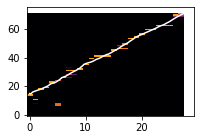

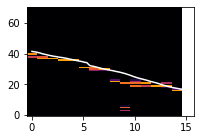

In [171]:
run_ind = 1
model_evidence, marginals = random(np.log(run_fk_1), 71)

print(model_evidence)
plt.figure(figsize=(3,2))
marginal_plot = get_marginal_sum(marginals)
plt.imshow(marginal_plot, aspect='auto', origin='lower', cmap='inferno', vmin=np.log(.005), vmax=np.log(4),interpolation='none')
t = np.linspace(0 , marginals.shape[1], data_run_raw.run_info['true_trajectories_cm'][run_ind].shape[0])
plt.plot(t, data_run_raw.run_info['true_trajectories_cm'][run_ind]/5, c='white')

run_ind = 17
model_evidence, marginals = random(np.log(run_fk_2), 71)

print(model_evidence)
plt.figure(figsize=(3,2))
marginal_plot = get_marginal_sum(marginals)
plt.imshow(marginal_plot, aspect='auto', origin='lower', cmap='inferno', vmin=np.log(.005), vmax=np.log(4),interpolation='none')
t = np.linspace(0 , marginals.shape[1], data_run_raw.run_info['true_trajectories_cm'][run_ind].shape[0])
plt.plot(t, data_run_raw.run_info['true_trajectories_cm'][run_ind]/5, c='white')

<ipython-input-170-7df94ed5223e>:1: RuntimeWarning: divide by zero encountered in log
  model_evidence, marginals = random(np.log(run_fk_rd_1), 71)


-2631.3385840637043
-2631.3385840637043
-983.4908807050033
-983.4908807050033


<ipython-input-170-7df94ed5223e>:16: RuntimeWarning: divide by zero encountered in log
  model_evidence, marginals = random(np.log(run_fk_rd_2), 71)


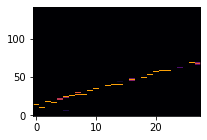

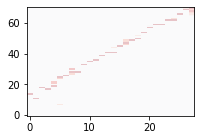

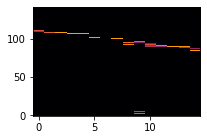

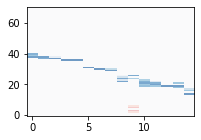

In [170]:
model_evidence, marginals = random(np.log(run_fk_rd_1), 71)

print(model_evidence)
plt.figure(figsize=(3,2))
marginal_plot = get_marginal_sum(marginals)
plt.imshow(marginal_plot, aspect='auto', origin='lower', cmap='inferno', vmin=np.log(.005), vmax=np.log(4),interpolation='none')

marginal_plot = get_marginal_sum(marginals)
pos = marginal_plot[:71,:]
neg = marginal_plot[71:,:]
print(model_evidence)
plt.figure(figsize=(3,2))
plt.imshow(pos, aspect='auto', origin='lower', cmap='Reds', alpha=0.6, vmin=np.log(.001), vmax=np.log(4), interpolation='none')
plt.imshow(neg, aspect='auto', origin='lower', cmap='Blues', alpha=0.6, vmin=np.log(.001), vmax=np.log(4), interpolation='none')

model_evidence, marginals = random(np.log(run_fk_rd_2), 71)

print(model_evidence)
plt.figure(figsize=(3,2))
marginal_plot = get_marginal_sum(marginals)
plt.imshow(marginal_plot, aspect='auto', origin='lower', cmap='inferno', vmin=np.log(.005), vmax=np.log(4),interpolation='none')

marginal_plot = get_marginal_sum(marginals)
pos = marginal_plot[:71,:]
neg = marginal_plot[71:,:]
print(model_evidence)
plt.figure(figsize=(3,2))
plt.imshow(pos, aspect='auto', origin='lower', cmap='Reds', alpha=0.6, vmin=np.log(.001), vmax=np.log(4), interpolation='none')
plt.imshow(neg, aspect='auto', origin='lower', cmap='Blues', alpha=0.6, vmin=np.log(.001), vmax=np.log(4), interpolation='none')

In [ ]:
# stationary

In [190]:
# stationary gaussian

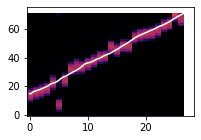

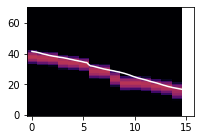

In [172]:
sd_meters = 0.1
sd_bins = (sd_meters*100) /structure_data.params.bin_size_cm

run_ind = 1
latent_mat = _calc_latent_probabilities_1D(structure_data.params.n_bins_x)
emission_probabilities = np.exp(calc_poisson_emission_probabilities_log(
                structure_data_run200.spikemats[run_ind],
                structure_data_run200.pf_matrix,
                0.2,
            ))
model_evidence, marginals = stat_gaus(emission_probabilities, structure_data.params.n_bins_x, latent_mat)
plt.figure(figsize=(3,2))
marginal_plot = get_marginal_sum(marginals)
plt.imshow(marginal_plot, aspect='auto', origin='lower', cmap='inferno', vmin=np.log(.01), vmax=np.log(4),interpolation='none')
t = np.linspace(0 , marginals.shape[1], data_run_raw.run_info['true_trajectories_cm'][run_ind].shape[0])
plt.plot(t, data_run_raw.run_info['true_trajectories_cm'][run_ind]/5, c='white')

run_ind = 17
latent_mat = _calc_latent_probabilities_1D(structure_data.params.n_bins_x)
emission_probabilities = np.exp(calc_poisson_emission_probabilities_log(
                structure_data_run200.spikemats[run_ind],
                structure_data_run200.pf_matrix,
                0.2,
            ))
model_evidence, marginals = stat_gaus(emission_probabilities, structure_data.params.n_bins_x, latent_mat)
plt.figure(figsize=(3,2))
marginal_plot = get_marginal_sum(marginals)
plt.imshow(marginal_plot, aspect='auto', origin='lower', cmap='inferno', vmin=np.log(.01), vmax=np.log(4),interpolation='none')
t = np.linspace(0 , marginals.shape[1], data_run_raw.run_info['true_trajectories_cm'][run_ind].shape[0])
plt.plot(t, data_run_raw.run_info['true_trajectories_cm'][run_ind]/5, c='w')

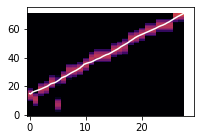

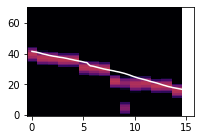

In [173]:
sd_meters = 0.1
sd_bins = (sd_meters*100) /5


latent_mat = _calc_latent_probabilities_1D(71)

run_ind = 1
model_evidence, marginals = stat_gaus(run_fk_1, 71, latent_mat)
plt.figure(figsize=(3,2))
marginal_plot = get_marginal_sum(marginals)
plt.imshow(marginal_plot, aspect='auto', origin='lower', cmap='inferno', vmin=np.log(.01), vmax=np.log(4),interpolation='none')
t = np.linspace(0 , marginals.shape[1], data_run_raw.run_info['true_trajectories_cm'][run_ind].shape[0])
plt.plot(t, data_run_raw.run_info['true_trajectories_cm'][run_ind]/5, c='w')

run_ind = 17
model_evidence, marginals = stat_gaus(run_fk_2, 71, latent_mat)
plt.figure(figsize=(3,2))
marginal_plot = get_marginal_sum(marginals)
plt.imshow(marginal_plot, aspect='auto', origin='lower', cmap='inferno', vmin=np.log(.01), vmax=np.log(4),interpolation='none')
t = np.linspace(0 , marginals.shape[1], data_run_raw.run_info['true_trajectories_cm'][run_ind].shape[0])
plt.plot(t, data_run_raw.run_info['true_trajectories_cm'][run_ind]/5, c='w')

-3505.9475345379865
-1053.2800664665442


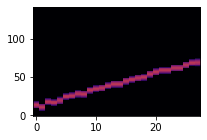

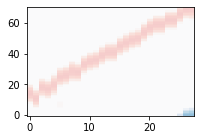

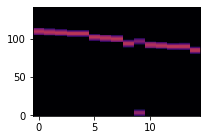

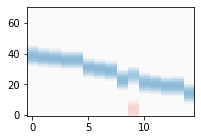

In [174]:
sd_meters = 0.1
sd_bins = (sd_meters*100) /5

latent_mat = _calc_latent_probabilities_1D(71*2)

model_evidence, marginals = stat_gaus(run_fk_rd_1, 71, latent_mat)
plt.figure(figsize=(3,2))
marginal_plot = get_marginal_sum(marginals)
plt.imshow(marginal_plot, aspect='auto', origin='lower', cmap='inferno', vmin=np.log(.01), vmax=np.log(4),interpolation='none')

pos = marginal_plot[:71,:]
neg = marginal_plot[71:,:]
print(model_evidence)
plt.figure(figsize=(3,2))
plt.imshow(pos, aspect='auto', origin='lower', cmap='Reds', alpha=0.6, vmin=np.log(.001), vmax=np.log(4), interpolation='none')
plt.imshow(neg, aspect='auto', origin='lower', cmap='Blues', alpha=0.6, vmin=np.log(.001), vmax=np.log(4), interpolation='none')

model_evidence, marginals = stat_gaus(run_fk_rd_2, 71, latent_mat)
plt.figure(figsize=(3,2))
marginal_plot = get_marginal_sum(marginals)
plt.imshow(marginal_plot, aspect='auto', origin='lower', cmap='inferno', vmin=np.log(.01), vmax=np.log(4),interpolation='none')

pos = marginal_plot[:71,:]
neg = marginal_plot[71:,:]
print(model_evidence)
plt.figure(figsize=(3,2))
plt.imshow(pos, aspect='auto', origin='lower', cmap='Reds', alpha=0.6, vmin=np.log(.001), vmax=np.log(4), interpolation='none')
plt.imshow(neg, aspect='auto', origin='lower', cmap='Blues', alpha=0.6, vmin=np.log(.001), vmax=np.log(4), interpolation='none')

-3461.295484838622
-1052.5869192859843


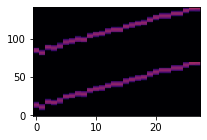

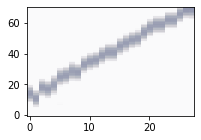

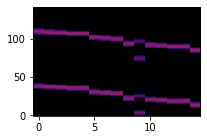

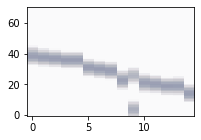

In [260]:
sd_meters = 0.1
sd_bins = (sd_meters*100) /5

latent_mat = _calc_latent_probabilities_1D(71)
latent_mat = np.vstack((latent_mat,latent_mat))
latent_mat = np.hstack((latent_mat,latent_mat))

model_evidence, marginals = stat_gaus(run_fk_rd_1, 71, latent_mat)
plt.figure(figsize=(3,2))
marginal_plot = get_marginal_sum(marginals)
plt.imshow(marginal_plot, aspect='auto', origin='lower', cmap='inferno', vmin=np.log(.01), vmax=np.log(4),interpolation='none')

pos = marginal_plot[:71,:]
neg = marginal_plot[71:,:]
print(model_evidence)
plt.figure(figsize=(3,2))
plt.imshow(pos, aspect='auto', origin='lower', cmap='Reds', alpha=0.6, vmin=np.log(.001), vmax=np.log(4), interpolation='none')
plt.imshow(neg, aspect='auto', origin='lower', cmap='Blues', alpha=0.6, vmin=np.log(.001), vmax=np.log(4), interpolation='none')

model_evidence, marginals = stat_gaus(run_fk_rd_2, 71, latent_mat)
plt.figure(figsize=(3,2))
marginal_plot = get_marginal_sum(marginals)
plt.imshow(marginal_plot, aspect='auto', origin='lower', cmap='inferno', vmin=np.log(.01), vmax=np.log(4),interpolation='none')

pos = marginal_plot[:71,:]
neg = marginal_plot[71:,:]
print(model_evidence)
plt.figure(figsize=(3,2))
plt.imshow(pos, aspect='auto', origin='lower', cmap='Reds', alpha=0.6, vmin=np.log(.001), vmax=np.log(4), interpolation='none')
plt.imshow(neg, aspect='auto', origin='lower', cmap='Blues', alpha=0.6, vmin=np.log(.001), vmax=np.log(4), interpolation='none')

In [ ]:
# diffusion

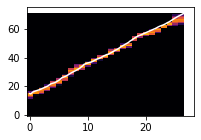

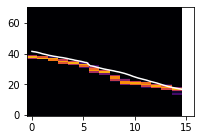

In [175]:
sd_meters = 0.14
sd_bins = (sd_meters*100) /structure_data.params.bin_size_cm
run_ind = 1
transition_matrix = _calc_transition_matrix(sd_bins, 0.2, structure_data.params.n_bins_x)
emission_probabilities = np.exp(calc_poisson_emission_probabilities_log(
                structure_data_run200.spikemats[run_ind],
                structure_data_run200.pf_matrix,
                0.2,
            ))
model_evidence, marginals = diffusion(emission_probabilities, transition_matrix, 
                                      sd_bins, 0.2, structure_data_run15.params.n_bins_x)
plt.figure(figsize=(3,2))
marginal_plot = get_marginal_sum(marginals)
plt.imshow(marginal_plot, aspect='auto', origin='lower', cmap='inferno', vmin=np.log(.001), vmax=np.log(4),interpolation='none')
t = np.linspace(0 , marginals.shape[1], data_run_raw.run_info['true_trajectories_cm'][run_ind].shape[0])
plt.plot(t, data_run_raw.run_info['true_trajectories_cm'][run_ind]/5, c='w')

run_ind = 17
transition_matrix = _calc_transition_matrix(sd_bins, 0.2, structure_data.params.n_bins_x)
emission_probabilities = np.exp(calc_poisson_emission_probabilities_log(
                structure_data_run200.spikemats[run_ind],
                structure_data_run200.pf_matrix,
                0.2,
            ))
model_evidence, marginals = diffusion(emission_probabilities, transition_matrix, 
                                      sd_bins, 0.2, structure_data_run15.params.n_bins_x)
plt.figure(figsize=(3,2))
marginal_plot = get_marginal_sum(marginals)
plt.imshow(marginal_plot, aspect='auto', origin='lower', cmap='inferno', vmin=np.log(.001), vmax=np.log(4),interpolation='none')
t = np.linspace(0 , marginals.shape[1], data_run_raw.run_info['true_trajectories_cm'][run_ind].shape[0])
plt.plot(t, data_run_raw.run_info['true_trajectories_cm'][run_ind]/5, c='w')

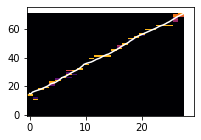

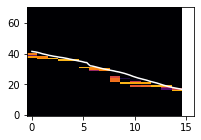

In [176]:
sd_meters = 0.14
sd_bins = (sd_meters*100) /5

transition_matrix = _calc_transition_matrix(sd_bins, 0.2, 71)
model_evidence, marginals = diffusion(run_fk_1, transition_matrix, sd_bins, 0.2, 71)
run_ind = 1
plt.figure(figsize=(3,2))
marginal_plot = get_marginal_sum(marginals)
plt.imshow(marginal_plot, aspect='auto', origin='lower', cmap='inferno', vmin=np.log(.001), vmax=np.log(4),interpolation='none')
t = np.linspace(0 , marginals.shape[1], data_run_raw.run_info['true_trajectories_cm'][run_ind].shape[0])
plt.plot(t, data_run_raw.run_info['true_trajectories_cm'][run_ind]/5, c='w')

run_ind = 17
model_evidence, marginals = diffusion(run_fk_2, transition_matrix, sd_bins, 0.2, 71)
plt.figure(figsize=(3,2))
marginal_plot = get_marginal_sum(marginals)
plt.imshow(marginal_plot, aspect='auto', origin='lower', cmap='inferno', vmin=np.log(.001), vmax=np.log(4),interpolation='none')
t = np.linspace(0 , marginals.shape[1], data_run_raw.run_info['true_trajectories_cm'][run_ind].shape[0])
plt.plot(t, data_run_raw.run_info['true_trajectories_cm'][run_ind]/5, c='w')

-2621.7440161476843
-969.5282865407115


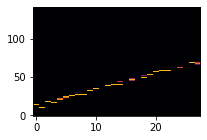

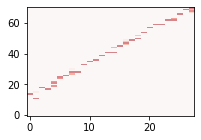

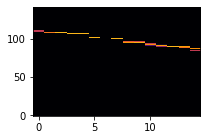

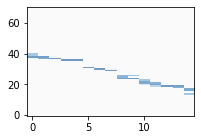

In [213]:
sd_meters = 0.14
sd_bins = (sd_meters*100) /5

transition_matrix = _calc_transition_matrix(sd_bins, 0.2, 71*2)

model_evidence, marginals = diffusion(run_fk_rd_1, transition_matrix, sd_bins, 0.015, 71*2)
plt.figure(figsize=(3,2))
marginal_plot = get_marginal_sum(marginals)
plt.imshow(marginal_plot, aspect='auto', origin='lower', cmap='inferno', vmin=np.log(.001), vmax=np.log(4),interpolation='none')
pos = marginal_plot[:71,:]
neg = marginal_plot[71:,:]
print(model_evidence)
plt.figure(figsize=(3,2))
plt.imshow(pos, aspect='auto', origin='lower', cmap='Reds', vmin=np.log(.001), vmax=np.log(4), interpolation='none')
plt.imshow(neg, aspect='auto', origin='lower', cmap='Blues',  alpha=0.5, vmin=np.log(.001), vmax=np.log(4), interpolation='none')

model_evidence, marginals = diffusion(run_fk_rd_2, transition_matrix, sd_bins, 0.015, 71*2)
plt.figure(figsize=(3,2))
marginal_plot = get_marginal_sum(marginals)
plt.imshow(marginal_plot, aspect='auto', origin='lower', cmap='inferno', vmin=np.log(.001), vmax=np.log(4),interpolation='none')
pos = marginal_plot[:71,:]
neg = marginal_plot[71:,:]
print(model_evidence)
plt.figure(figsize=(3,2))
plt.imshow(pos, aspect='auto', origin='lower', cmap='Reds', alpha=0.6,vmin=np.log(.001), vmax=np.log(4), interpolation='none')
plt.imshow(neg, aspect='auto', origin='lower', cmap='Blues',  alpha=0.6, vmin=np.log(.001), vmax=np.log(4), interpolation='none')

-3184.9827926668877
-1166.20675182151


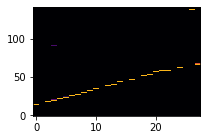

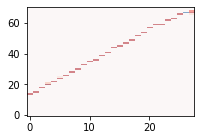

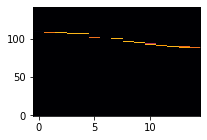

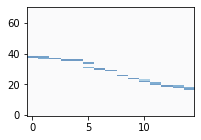

In [214]:
sd_meters = 0.14
sd_bins = (sd_meters*100) /5

transition_matrix = _calc_transition_matrix(sd_bins, 0.015, 71)
transition_matrix = np.vstack((transition_matrix,transition_matrix))
transition_matrix = np.hstack((transition_matrix,transition_matrix))

model_evidence, marginals = diffusion(run_fk_rd_1, transition_matrix, sd_bins, 0.015, 71*2)
plt.figure(figsize=(3,2))
marginal_plot = get_marginal_sum(marginals)
plt.imshow(marginal_plot, aspect='auto', origin='lower', cmap='inferno', vmin=np.log(.001), vmax=np.log(4),interpolation='none')
pos = marginal_plot[:71,:]
neg = marginal_plot[71:,:]
print(model_evidence)
plt.figure(figsize=(3,2))
plt.imshow(pos, aspect='auto', origin='lower', cmap='Reds', vmin=np.log(.001), vmax=np.log(4), interpolation='none')
plt.imshow(neg, aspect='auto', origin='lower', cmap='Blues',  alpha=0.5, vmin=np.log(.001), vmax=np.log(4), interpolation='none')

model_evidence, marginals = diffusion(run_fk_rd_2, transition_matrix, sd_bins, 0.015, 71*2)
plt.figure(figsize=(3,2))
marginal_plot = get_marginal_sum(marginals)
plt.imshow(marginal_plot, aspect='auto', origin='lower', cmap='inferno', vmin=np.log(.001), vmax=np.log(4),interpolation='none')
pos = marginal_plot[:71,:]
neg = marginal_plot[71:,:]
print(model_evidence)
plt.figure(figsize=(3,2))
plt.imshow(pos, aspect='auto', origin='lower', cmap='Reds', alpha=0.6, vmin=np.log(.001), vmax=np.log(4), interpolation='none')
plt.imshow(neg, aspect='auto', origin='lower', cmap='Blues',  alpha=0.6, vmin=np.log(.001), vmax=np.log(4), interpolation='none')

In [278]:
# momentum

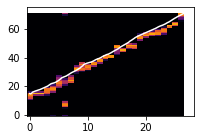

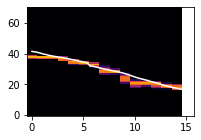

In [215]:
sd_meters = 130
sd_0_meters = 0.03
sd_bins = (sd_meters*100) /structure_data.params.bin_size_cm
sd_0_bins = (sd_0_meters*100) /structure_data.params.bin_size_cm
decay = 20

run_ind = 1
emission_probabilities = np.exp(calc_poisson_emission_probabilities_log(
                structure_data_run200.spikemats[run_ind],
                structure_data_run200.pf_matrix,
                0.2,
            ))
initial_transition = _calc_transition_matrix(sd_0_bins, 0.2, 71, norm=1)
transition_matrix = _calc_order2_transition_matrix(sd_bins, decay, 0.2, 71)

model_ev, marginals = momentum(emission_probabilities, initial_transition, transition_matrix, 71)
plt.figure(figsize=(3,2))
marginal_plot = get_marginal_sum(marginals)
plt.imshow(marginal_plot, aspect='auto', origin='lower', cmap='inferno', vmin=np.log(.001), vmax=np.log(4),interpolation='none')
t = np.linspace(0 , marginals.shape[1], data_run_raw.run_info['true_trajectories_cm'][run_ind].shape[0])
plt.plot(t, data_run_raw.run_info['true_trajectories_cm'][run_ind]/5, c='w')

run_ind = 17
emission_probabilities = np.exp(calc_poisson_emission_probabilities_log(
                structure_data_run200.spikemats[run_ind],
                structure_data_run200.pf_matrix,
                0.2,
            ))
initial_transition = _calc_transition_matrix(sd_0_bins, 0.2, 71, norm=1)
transition_matrix = _calc_order2_transition_matrix(sd_bins, decay, 0.2, 71)

model_ev, marginals = momentum(emission_probabilities, initial_transition, transition_matrix, 71)
plt.figure(figsize=(3,2))
marginal_plot = get_marginal_sum(marginals)
plt.imshow(marginal_plot, aspect='auto', origin='lower', cmap='inferno', vmin=np.log(.001), vmax=np.log(4),interpolation='none')
t = np.linspace(0 , marginals.shape[1], data_run_raw.run_info['true_trajectories_cm'][run_ind].shape[0])
plt.plot(t, data_run_raw.run_info['true_trajectories_cm'][run_ind]/5, c='w')

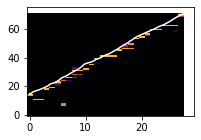

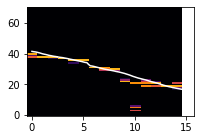

In [210]:
initial_transition = _calc_transition_matrix(sd_0_bins, 0.2, 71, norm=1)
transition_matrix = _calc_order2_transition_matrix(sd_bins, decay, 0.2, 71)
run_ind = 1
model_ev, marginals = momentum(run_fk_1, initial_transition, transition_matrix, 71)
plt.figure(figsize=(3,2))
marginal_plot = get_marginal_sum(marginals)
plt.imshow(marginal_plot, aspect='auto', origin='lower', vmin=np.log(.001), vmax=np.log(4), cmap='inferno', interpolation='none')
t = np.linspace(0 , marginals.shape[1], data_run_raw.run_info['true_trajectories_cm'][run_ind].shape[0])
plt.plot(t, data_run_raw.run_info['true_trajectories_cm'][run_ind]/5, c='w')

run_ind = 17
model_ev, marginals = momentum(run_fk_2, initial_transition, transition_matrix, 71)
plt.figure(figsize=(3,2))
marginal_plot = get_marginal_sum(marginals)
plt.imshow(marginal_plot, aspect='auto', origin='lower', vmin=np.log(.001), vmax=np.log(4), cmap='inferno', interpolation='none')
t = np.linspace(0 , marginals.shape[1], data_run_raw.run_info['true_trajectories_cm'][run_ind].shape[0])
plt.plot(t, data_run_raw.run_info['true_trajectories_cm'][run_ind]/5, c='w')

In [211]:
print(marginal_plot.min(), marginal_plot.max())

-3.4028235e+38 0.0


-1166.20675182151
-1166.20675182151


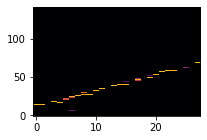

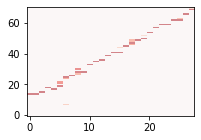

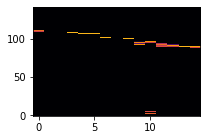

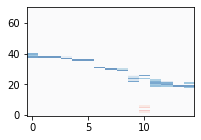

In [220]:
initial_transition = _calc_transition_matrix(sd_0_bins, 0.2, 71*2, norm=1)
transition_matrix = _calc_order2_transition_matrix(sd_bins, decay, 0.2, 71*2)
run_ind = 1
model_ev, marginals = momentum(run_fk_rd_1, initial_transition, transition_matrix, 71*2)
plt.figure(figsize=(3,2))
marginal_plot = get_marginal_sum(marginals)
plt.imshow(marginal_plot, aspect='auto', origin='lower', vmin=np.log(.001), vmax=np.log(4), cmap='inferno', interpolation='none')

pos = marginal_plot[:71,:]
neg = marginal_plot[71:,:]
print(model_evidence)
plt.figure(figsize=(3,2))
plt.imshow(pos, aspect='auto', origin='lower', cmap='Reds', vmin=np.log(.001), vmax=np.log(4), interpolation='none')
plt.imshow(neg, aspect='auto', origin='lower', cmap='Blues',  alpha=0.5, vmin=np.log(.001), vmax=np.log(4), interpolation='none')

run_ind = 17
model_ev, marginals = momentum(run_fk_rd_2, initial_transition, transition_matrix, 71*2)
plt.figure(figsize=(3,2))
marginal_plot = get_marginal_sum(marginals)
plt.imshow(marginal_plot, aspect='auto', origin='lower', vmin=np.log(.001), vmax=np.log(4), cmap='inferno', interpolation='none')

pos = marginal_plot[:71,:]
neg = marginal_plot[71:,:]
print(model_evidence)
plt.figure(figsize=(3,2))
plt.imshow(pos, aspect='auto', origin='lower', cmap='Reds', alpha=0.6, vmin=np.log(.001), vmax=np.log(4), interpolation='none')
plt.imshow(neg, aspect='auto', origin='lower', cmap='Blues',  alpha=0.6, vmin=np.log(.001), vmax=np.log(4), interpolation='none')

-1166.20675182151
-1166.20675182151


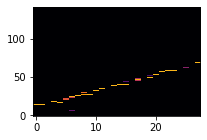

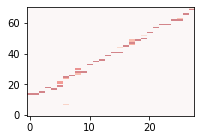

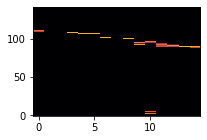

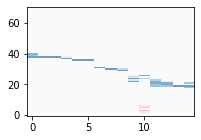

In [237]:
initial_transition = _calc_transition_matrix(sd_0_bins, 0.2, 71, norm=2)
initial_transition = np.vstack((initial_transition,initial_transition))
initial_transition = np.hstack((initial_transition,initial_transition))

transition_matrix = _calc_order2_transition_matrix(sd_bins, decay, 0.2, 71)
transition_matrix = np.concatenate((transition_matrix, transition_matrix), axis=0)
transition_matrix = np.concatenate((transition_matrix, transition_matrix), axis=1)
transition_matrix = np.concatenate((transition_matrix, transition_matrix), axis=2)

run_ind = 1
model_ev, marginals = momentum(run_fk_rd_1, initial_transition, transition_matrix, 71*2)
plt.figure(figsize=(3,2))
marginal_plot = get_marginal_sum(marginals)
plt.imshow(marginal_plot, aspect='auto', origin='lower', vmin=np.log(.001), vmax=np.log(4), cmap='inferno', interpolation='none')

pos = marginal_plot[:71,:]
neg = marginal_plot[71:,:]
print(model_evidence)
plt.figure(figsize=(3,2))
plt.imshow(pos, aspect='auto', origin='lower', cmap='Reds', vmin=np.log(.001), vmax=np.log(4), interpolation='none')
plt.imshow(neg, aspect='auto', origin='lower', cmap='Blues',  alpha=0.5, vmin=np.log(.001), vmax=np.log(4), interpolation='none')

run_ind = 17
model_ev, marginals = momentum(run_fk_rd_2, initial_transition, transition_matrix, 71*2)
plt.figure(figsize=(3,2))
marginal_plot = get_marginal_sum(marginals)
plt.imshow(marginal_plot, aspect='auto', origin='lower', vmin=np.log(.001), vmax=np.log(4), cmap='inferno', interpolation='none')

pos = marginal_plot[:71,:]
neg = marginal_plot[71:,:]
print(model_evidence)
plt.figure(figsize=(3,2))
plt.imshow(pos, aspect='auto', origin='lower', cmap='Reds', alpha=0.6, vmin=np.log(.001), vmax=np.log(4), interpolation='none')
plt.imshow(neg, aspect='auto', origin='lower', cmap='Blues',  alpha=0.6, vmin=np.log(.001), vmax=np.log(4), interpolation='none')

## Ripples

-90.37420227570524


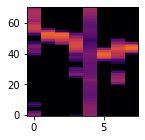

In [200]:
# random
emission_probabilities_log = calc_poisson_emission_probabilities_log(
                structure_data.spikemats[index],
                structure_data.pf_matrix,
                0.015,
            )
model_evidence, marginals = random(emission_probabilities_log, structure_data.params.n_bins_x)

print(model_evidence)
plt.figure(figsize=(2,2))
marginal_plot = get_marginal_sum(marginals)
plt.imshow(marginal_plot, aspect='auto', origin='lower', cmap='inferno', vmin=np.log(.001), vmax=np.log(4),interpolation='none')

-1754.7596336195015


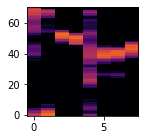

In [201]:
model_evidence, marginals = random(np.log(ripple_fk), 71)

print(model_evidence)
plt.figure(figsize=(2,2))
marginal_plot = get_marginal_sum(marginals)
plt.imshow(marginal_plot, aspect='auto', origin='lower', cmap='inferno', vmin=np.log(.001), vmax=np.log(4),interpolation='none')

-1752.7005916273265


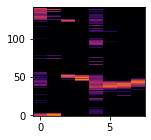

In [238]:
model_evidence, marginals = random(np.log(ripple_fk_rd), 71*2)

print(model_evidence)
plt.figure(figsize=(2,2))
marginal_plot = get_marginal_sum(marginals)
plt.imshow(marginal_plot, aspect='auto', origin='lower', cmap='inferno', vmin=np.log(.001), vmax=np.log(4),interpolation='none')

-1752.7005916273265


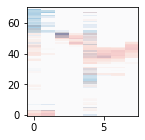

In [239]:
marginal_plot = get_marginal_sum(marginals)
pos = marginal_plot[:71,:]
neg = marginal_plot[71:,:]
print(model_evidence)
plt.figure(figsize=(2,2))
plt.imshow(pos, aspect='auto', origin='lower', cmap='Reds', alpha=0.6, vmin=np.log(.001), vmax=np.log(4), interpolation='none')
plt.imshow(neg, aspect='auto', origin='lower', cmap='Blues',  alpha=0.6, vmin=np.log(.001), vmax=np.log(4), interpolation='none')

-98.62316190448539


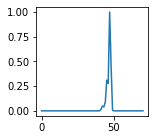

In [255]:
# stationary
emission_probability_log = calc_poisson_emission_probability_log(
                structure_data.spikemats[index],
                structure_data.pf_matrix,
                0.015,
            )

model_evidence, marginals = stationary(emission_probability_log, structure_data.params.n_bins_x)
print(model_evidence)
plt.figure(figsize=(2,2))
plt.plot(marginals)

-210.16397345693224


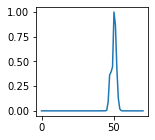

In [206]:
model_evidence, marginals = stationary( np.log(np.sum(ripple_fk, axis=1)), 71)
print(model_evidence)
plt.figure(figsize=(2,2))
plt.plot(marginals)

-210.4271022337404


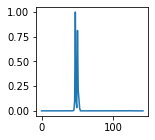

In [207]:
model_evidence, marginals = stationary(np.log(np.sum(ripple_fk_rd, axis=1)), 71*2)
print(model_evidence)
plt.figure(figsize=(2,2))
plt.plot(marginals)

In [ ]:
# stationary gaussian

-91.09439231659728


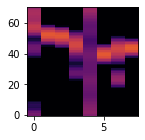

In [208]:
sd_meters = 0.08
sd_bins = (sd_meters*100) /structure_data.params.bin_size_cm

latent_mat = _calc_latent_probabilities_1D(structure_data.params.n_bins_x)
emission_probabilities = np.exp(calc_poisson_emission_probabilities_log(
                structure_data.spikemats[index],
                structure_data.pf_matrix,
                0.015,
            ))
model_evidence, marginals = stat_gaus(emission_probabilities, structure_data.params.n_bins_x, latent_mat)
print(model_evidence)
plt.figure(figsize=(2,2))
marginal_plot = get_marginal_sum(marginals)
plt.imshow(marginal_plot, aspect='auto', origin='lower', cmap='inferno', vmin=np.log(.001), vmax=np.log(4),interpolation='none')

-1761.2695213287843


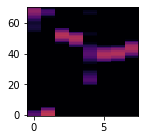

In [209]:
sd_meters = 0.08
sd_bins = (sd_meters*100) /5

latent_mat = _calc_latent_probabilities_1D(71)

model_evidence, marginals = stat_gaus(ripple_fk, 71, latent_mat)
print(model_evidence)
plt.figure(figsize=(2,2))
marginal_plot = get_marginal_sum(marginals)
plt.imshow(marginal_plot, aspect='auto', origin='lower', cmap='inferno', vmin=np.log(.01), vmax=np.log(4),interpolation='none')

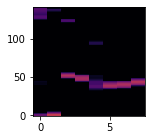

In [240]:
sd_meters = 0.08
sd_bins = (sd_meters*100) /5

latent_mat = _calc_latent_probabilities_1D(71*2)

model_evidence, marginals = stat_gaus(ripple_fk_rd, 71, latent_mat)
plt.figure(figsize=(2,2))
marginal_plot = get_marginal_sum(marginals)
plt.imshow(marginal_plot, aspect='auto', origin='lower', cmap='inferno', vmin=np.log(.01), vmax=np.log(4),interpolation='none')

-1751.7112356657813


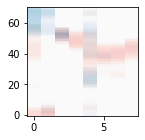

In [241]:
marginal_plot = get_marginal_sum(marginals)
pos = marginal_plot[:71,:]
neg = marginal_plot[71:,:]
print(model_evidence)
plt.figure(figsize=(2,2))
plt.imshow(pos, aspect='auto', origin='lower', cmap='Reds', alpha=0.6, vmin=np.log(.001), vmax=np.log(4), interpolation='none')
plt.imshow(neg, aspect='auto', origin='lower', cmap='Blues',  alpha=0.6, vmin=np.log(.001), vmax=np.log(4), interpolation='none')

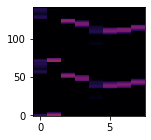

In [242]:
sd_meters = 0.08
sd_bins = (sd_meters*100) /5

latent_mat = _calc_latent_probabilities_1D(71,2)
latent_mat = np.vstack((latent_mat,latent_mat))
latent_mat = np.hstack((latent_mat,latent_mat))

model_evidence, marginals = stat_gaus(ripple_fk_rd, 71, latent_mat)
plt.figure(figsize=(2,2))
marginal_plot = get_marginal_sum(marginals)
plt.imshow(marginal_plot, aspect='auto', origin='lower', cmap='inferno', vmin=np.log(.01), vmax=np.log(4),interpolation='none')

-1756.4478887159883


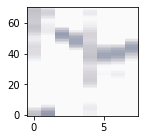

In [243]:
marginal_plot = get_marginal_sum(marginals)
pos = marginal_plot[:71,:]
neg = marginal_plot[71:,:]
print(model_evidence)
plt.figure(figsize=(2,2))
plt.imshow(pos, aspect='auto', origin='lower', cmap='Reds', alpha=0.6, vmin=np.log(.001), vmax=np.log(4), interpolation='none')
plt.imshow(neg, aspect='auto', origin='lower', cmap='Blues',  alpha=0.6, vmin=np.log(.001), vmax=np.log(4), interpolation='none')

In [213]:
# diffusion

-84.57141301735555


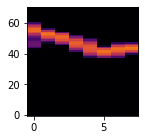

In [244]:
sd_meters = 0.98
sd_bins = (sd_meters*100) /structure_data.params.bin_size_cm

transition_matrix = _calc_transition_matrix(sd_bins, 0.015, structure_data.params.n_bins_x)
emission_probabilities = np.exp(calc_poisson_emission_probabilities_log(
                structure_data.spikemats[index],
                structure_data.pf_matrix,
                0.015,
            ))
model_evidence, marginals = diffusion(emission_probabilities, transition_matrix, 
                                      sd_bins, 0.015, structure_data_run15.params.n_bins_x)
print(model_evidence)
plt.figure(figsize=(2,2))
marginal_plot = get_marginal_sum(marginals)
plt.imshow(marginal_plot, aspect='auto', origin='lower', cmap='inferno', vmin=np.log(.001), vmax=np.log(4),interpolation='none')

-1753.268811132407


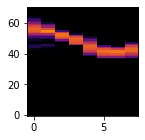

In [214]:
sd_meters = 0.98
sd_bins = (sd_meters*100) /5

transition_matrix = _calc_transition_matrix(sd_bins, 0.015, 71)

model_evidence, marginals = diffusion(ripple_fk, transition_matrix, 
                                      sd_bins, 0.015, 71)
print(model_evidence)
plt.figure(figsize=(2,2))
marginal_plot = get_marginal_sum(marginals)
plt.imshow(marginal_plot, aspect='auto', origin='lower', cmap='inferno', vmin=np.log(.001), vmax=np.log(4),interpolation='none')

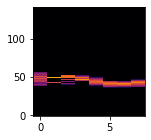

In [245]:
transition_matrix = _calc_transition_matrix(sd_bins, 0.015, 71*2)

model_evidence, marginals = diffusion(ripple_fk_rd, transition_matrix, 
                                      sd_bins, 0.015, 71*2)
plt.figure(figsize=(2,2))
marginal_plot = get_marginal_sum(marginals)
plt.imshow(marginal_plot, aspect='auto', origin='lower', cmap='inferno', vmin=np.log(.001), vmax=np.log(4),interpolation='none')

-1749.6332263056136


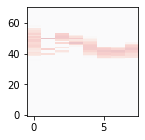

In [246]:
marginal_plot = get_marginal_sum(marginals)
pos = marginal_plot[:71,:]
neg = marginal_plot[71:,:]
print(model_evidence)
plt.figure(figsize=(2,2))
plt.imshow(pos, aspect='auto', origin='lower', cmap='Reds', alpha=0.6, vmin=np.log(.001), vmax=np.log(4), interpolation='none')
plt.imshow(neg, aspect='auto', origin='lower', cmap='Blues',  alpha=0.6, vmin=np.log(.001), vmax=np.log(4), interpolation='none')

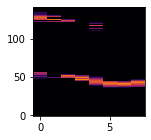

In [249]:
transition_matrix = _calc_transition_matrix(sd_bins, 0.015, 71, 2)
transition_matrix = np.vstack((transition_matrix,transition_matrix))
transition_matrix = np.hstack((transition_matrix,transition_matrix))

model_evidence, marginals = diffusion(ripple_fk_rd, transition_matrix, 
                                      sd_bins, 0.015, 71*2)
plt.figure(figsize=(2,2))
marginal_plot = get_marginal_sum(marginals)
plt.imshow(marginal_plot, aspect='auto', origin='lower', cmap='inferno', vmin=np.log(.001), vmax=np.log(4),interpolation='none')

-1749.2201761553072


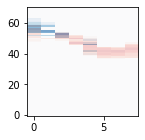

In [250]:
marginal_plot = get_marginal_sum(marginals)
pos = marginal_plot[:71,:]
neg = marginal_plot[71:,:]
print(model_evidence)
plt.figure(figsize=(2,2))
plt.imshow(pos, aspect='auto', origin='lower', cmap='Reds', alpha=0.6, vmin=np.log(.001), vmax=np.log(4), interpolation='none')
plt.imshow(neg, aspect='auto', origin='lower', cmap='Blues',  alpha=0.6, vmin=np.log(.001), vmax=np.log(4), interpolation='none')

In [ ]:
# momentum

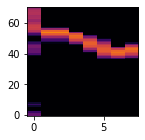

In [251]:
sd_meters = 130
sd_0_meters = 0.03
sd_bins = (sd_meters*100) /structure_data.params.bin_size_cm
sd_0_bins = (sd_0_meters*100) /structure_data.params.bin_size_cm
decay = 100


emission_probabilities = np.exp(calc_poisson_emission_probabilities_log(
                structure_data.spikemats[index],
                structure_data_run15.pf_matrix,
                0.015,
            ))
initial_transition = _calc_transition_matrix(sd_0_bins, 0.015, 71, norm=1)
transition_matrix = _calc_order2_transition_matrix(sd_bins, decay, 0.015, 71)

model_ev, marginals = momentum(emission_probabilities, initial_transition, transition_matrix, 71)
plt.figure(figsize=(2,2))
marginal_plot = get_marginal_sum(marginals)
plt.imshow(marginal_plot, aspect='auto', origin='lower', cmap='inferno', vmin=np.log(.001), vmax=np.log(4),interpolation='none')

-1767.2625966831352791


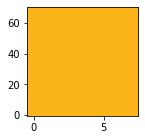

In [267]:
sd_meters = 10
sd_0_meters = 0.14
sd_bins = (sd_meters*100) /structure_data.params.bin_size_cm
sd_0_bins = (sd_0_meters*100) /structure_data.params.bin_size_cm
decay = 20

initial_transition = _calc_transition_matrix(sd_0_bins, 0.015, 71, norm=1)
transition_matrix = _calc_order2_transition_matrix(sd_bins, decay, 0.015, 71)

model_ev, marginals = momentum(ripple_fk, initial_transition, transition_matrix, 71)
print(model_ev)
plt.figure(figsize=(2,2))
marginal_plot = get_marginal_sum(marginals)
plt.imshow(marginal_plot, aspect='auto', origin='lower', cmap='inferno', vmin=np.log(.001), vmax=np.log(4),interpolation='none')

# Viterbi trajectory decoding

In [22]:
import replay_structure.utils as utils
from replay_structure.structure_analysis_input import Structure_Analysis_Input
from replay_structure.config import Structure_Analysis_Input_Parameters
from replay_structure.metadata import Poisson_Params, Neg_Binomial_Params
from replay_structure.viterbi import Viterbi

In [83]:
dif_sd_meters = np.array([1.74, 0.64, 2.32, 0.98, 0.31, 0.74, 0.1 , 0.36, 1.14, 2.68, 3.09,
       0.1 , 2.68, 3.09, 2.32, 0.1 , 0.1 , 0.1 , 0.1 , 4.11, 4.74, 4.11,
       2.32, 2.68, 2.32, 0.85, 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.85, 0.1 ,
       0.42, 2.32, 2.01, 1.14, 0.1 , 0.98, 1.74, 2.68, 0.1 , 4.74, 4.11,
       0.1 , 0.1 , 1.31, 1.51, 2.68, 0.1 , 0.98, 0.24, 6.31, 2.68, 0.1 ,
       1.31, 0.1 , 1.31, 0.56, 5.47, 0.42, 3.09, 0.98, 0.1 , 3.56, 0.1 ,
       0.56, 1.74, 1.74, 0.1 , 0.98, 2.32, 0.56, 0.24, 0.42, 0.98, 0.1 ,
       1.14, 1.31, 0.1 , 6.31, 2.01, 0.98, 6.31, 4.74, 0.64, 0.36, 1.51,
       1.74, 0.1 , 4.11, 0.1 , 0.1 , 0.1 , 0.1 , 0.98, 1.31, 1.74, 2.01,
       1.51, 0.85, 3.09, 0.1 , 1.51, 0.98, 0.1 , 2.01, 0.1 , 3.56, 1.51,
       0.1 , 1.74, 0.1 , 0.1 , 0.74, 1.51, 2.01, 0.24, 2.32, 0.48, 1.51,
       0.1 , 0.1 , 0.85, 0.1 , 0.2 , 0.56, 6.31, 0.56, 0.98, 6.31, 2.32,
       6.31, 0.1 , 0.24, 2.68, 1.31, 0.48, 1.74, 4.11, 0.1 , 0.56, 1.14,
       0.1 , 0.1 , 1.14, 1.74, 3.09, 0.1 , 0.98, 6.31, 0.64, 2.32, 0.1 ,
       3.56, 3.09, 2.32, 3.56, 0.1 , 0.1 , 0.1 , 0.13, 0.1 , 0.1 , 0.1 ,
       0.1 , 0.1 , 6.31, 2.01, 1.31, 0.74, 0.98, 0.1 , 0.74, 2.32, 0.1 ,
       0.1 , 0.98, 1.51, 0.1 , 1.74, 0.31, 0.98, 0.1 , 0.1 , 1.74, 0.1 ,
       3.56, 0.1 , 1.51, 6.31, 0.36, 0.2 , 3.56, 0.56, 0.85, 1.74, 1.74,
       0.1 , 0.1 , 0.42, 0.1 , 0.74, 1.74, 1.51, 1.14, 0.42, 3.56, 0.42,
       1.31, 0.1 , 1.31, 0.1 , 1.51, 1.31, 1.31, 2.01, 1.51, 0.85, 0.1 ,
       1.14, 2.68, 0.1 , 2.32, 0.56, 2.32, 0.1 , 0.31, 2.32, 0.2 , 1.14,
       0.1 , 0.1 , 0.1 , 0.1 , 0.24, 3.56, 0.1 , 0.1 , 2.01, 2.01, 1.14,
       1.74, 0.15, 1.74, 3.09, 0.56, 0.1 , 1.14, 2.32, 1.51, 6.31, 1.51,
       0.31, 6.31, 2.32, 0.1 , 0.1 , 0.48, 0.1 , 0.74, 0.1 , 0.1 , 0.1 ,
       0.85, 0.1 , 3.09, 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.56, 0.1 ,
       2.01, 0.1 , 0.85, 0.1 , 0.31, 0.36, 0.64, 0.1 , 1.51, 0.1 , 0.18,
       0.42, 4.74, 6.31, 0.1 , 6.31, 1.14, 6.31, 0.1 ])

In [91]:
index = 23

In [92]:
sd_meters = 0.98
sd_meters = dif_sd_meters[index]
sd_bins = (sd_meters*100) /structure_data.params.bin_size_cm

In [93]:
# initialize virerbi
viterbi_input = dict()
viterbi_input["initial_state_prior"] = (
            np.ones(structure_data.params.n_bins_x) / structure_data.params.n_bins_x)
viterbi_input["emission_probabilities"] = np.exp(
            calc_poisson_emission_probabilities_log(structure_data.spikemats[index],
                structure_data.pf_matrix, emission_prob_time_window,))
viterbi_input["transition_matrix"] = _calc_order1_transition_matrix1D(sd_bins)

In [94]:
viterbi_outputs = Viterbi(viterbi_input).run_viterbi_algorithm()
most_likely_trajectory = viterbi_outputs["z_max"]

In [95]:
most_likely_trajectory.shape

(12,)

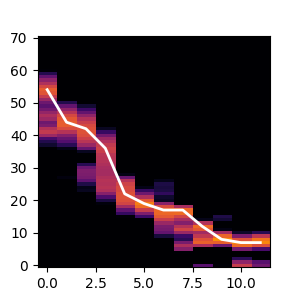

In [96]:
# marginal = models.Momentum(structure_data, 1, 90, 80, plotting=True).get_spikemat_marginals(index)
marginal = models.Diffusion(structure_data, dif_sd_meters[index]).get_spikemat_marginals(index)

marginal_plot = get_marginal_sum(marginal)

plt.figure(figsize=(3,3))
plt.imshow(marginal_plot,aspect='auto', origin='lower', cmap='inferno',vmin=np.log(.001), vmax=np.log(4),interpolation='none')
plt.plot(most_likely_trajectory, c="white", lw="2")